**Connecting colab with kaggal to download dataset**

In [8]:
!pip install --upgrade --ignore-installed kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached urllib3-1.26.13-py2.py3-none-any.whl (140 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached python_slugify-7.0.0-py2.py3-none-any.whl (9.4 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached charset_normalizer-2.1.1-py3-none-any.whl (39 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [26]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sabafatimaa1101","key":"25d476a72cc1761b45e90058aaf3575e"}'}

In [ ]:
!mkdir ~/.kaggle #created at root folder in colab

In [28]:
#copy
!cp kaggle.json ~/.kaggle

In [29]:
! chmod 600 ~/.kaggle/kaggle.json

In [30]:
# ! kaggle datasets list

In [31]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet 

**Sending data to google drive**

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# copy zipped dataset into your drive
!cp "/content/intel-image-classification.zip" /content/drive/MyDrive/

**Importing required libraries**

In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import pathlib
import cv2 as cv
from tensorflow.keras.layers import Dense, RandomFlip, RandomRotation, RandomZoom, RandomWidth, RandomHeight, Rescaling
from tensorflow.keras import Sequential
from tensorflow.keras.activations import softmax

**Setting up Random Seed**

If you seed the random number generator before creating the model, the weights will be initialized with the same values each time the model is created, which can be useful for debugging or comparing different versions of the model.

In general, seeding the random number generator can be useful when you want to ensure that the results of your model are reproducible and consistent across different runs.

In [41]:
RANDOM_SEED: int = 42

In [42]:
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.experimental.numpy.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

**Setting up Hyperparameters**



1.   BATCH_SIZE is a hyperparameter that determines the number of samples that the model processes at a time during training. A larger batch size can lead to faster training, but it can also use more memory and may not generalize as well to new data. A smaller batch size can take longer to train, but it may be more memory efficient and may generalize better to new data.
2.   EPOCHS is a hyperparameter that determines the number of times the model sees the entire training dataset during training. An epoch is a complete pass through the training dataset. For example, if the training dataset has 1000 samples and the batch size is 32, it will take 32 batches to complete one epoch. If the number of epochs is set to 10, the model will see the entire training dataset 10 times during training.
(In this model, it will see a total of 32 * 10 * (number of batches in the training dataset) samples during training.)


3.   AUGMENTATION_FACTOR is a hyperparameter that is used to control the amount of data augmentation applied to a dataset, and
2.   LABEL_MODEL is the type of label model being used for classification. 

In [77]:
BATCH_SIZE: int = 32
EPOCHS: int = 5
IMAGE_SIZE = (150, 150)
AUGMENTATION_FACTOR: float = 0.2
LABEL_MODEL: str = "categorical"


**Exploring and Preprocessing data**

**Get class names (labels)**

In [44]:
import pathlib
data_dir = pathlib.Path("/content/seg_train/seg_train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])).tolist() # created a list of class_names from the subdirector
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

**Setting directories and Checking the type of images in each set**

In [45]:
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'

print("type of Images in Train dataset"+str(os.listdir(train_path)))
print("type of Images in Test dataset"+str(os.listdir(test_path)))

type of Images in Train dataset['mountain', 'buildings', 'street', 'forest', 'sea', 'glacier']
type of Images in Test dataset['mountain', 'buildings', 'street', 'forest', 'sea', 'glacier']


**Getting number of files in each folder**

In [46]:
print("Training data:")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_path,
    label_mode=LABEL_MODEL,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    shuffle=True
)

print("Testing data:")
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_path,
    label_mode=LABEL_MODEL,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED,
    shuffle=False
)

Training data:
Found 14034 files belonging to 6 classes.
Testing data:
Found 3000 files belonging to 6 classes.


**Visualize random image from dataset**

Image shape: (150, 150, 3)


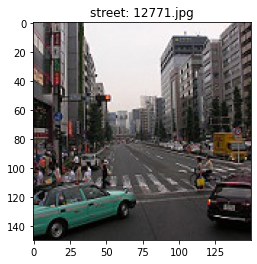

In [47]:
# visualize random image from train set
target_class = random.choice(class_names)
target_folder: str = '/content/seg_train/seg_train/' + target_class

# Get a random image path
random_image = random.sample(os.listdir(target_folder), 1)

# Read in the image and plot it using matplotlib
img = mpimg.imread(target_folder + "/" + random_image[0])
plt.imshow(img)
plt.title(f"{target_class}: {random_image[0]}")

print(f"Image shape: {img.shape}")

**Visualize image from each class label**

Here in code line i.e. plt.imshow(image[:, :, ::-1]), 


*   the expression image[:, :, ::-1] is a slicing operation that is applied to the image array. It extracts a slice of the array that includes all rows, all columns, and all channels of the image array, but in reverse order.

*   The ::-1 slice syntax means to start at the end of the array and step backwards. So, the slicing operation is essentially reversing the order of the channels in the image array

The reason for reversing the channel order is that the default channel order for images in Matplotlib is RGB (red, green, blue), whereas the channel order for images in many image processing libraries, including TensorFlow, is typically BGR (blue, green, red). Reversing the channel order allows the image to be displayed correctly using Matplotlib.


mountain images:


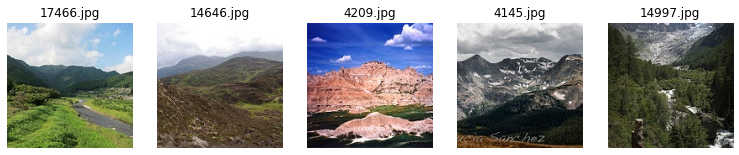

buildings images:


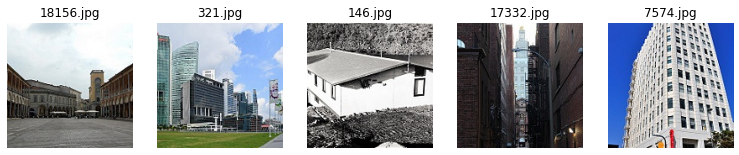

street images:


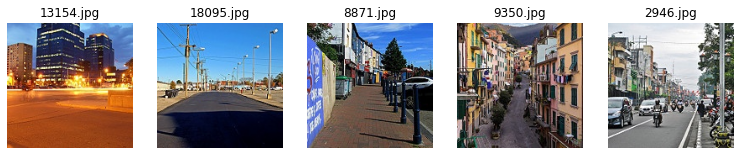

forest images:


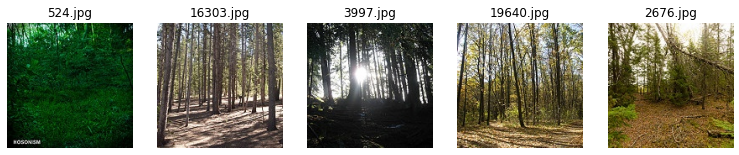

sea images:


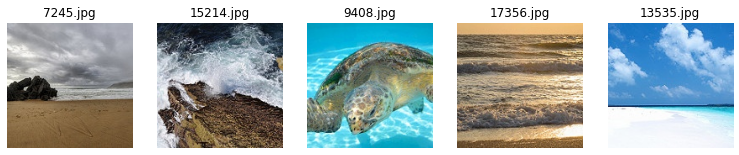

glacier images:


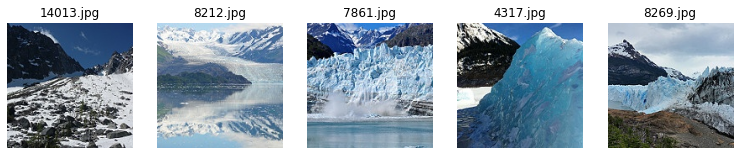

In [48]:
rows, cols = (1, 5)
import matplotlib.pyplot as plt
for categories in os.listdir(train_path):
    print(f'{categories} images:')
    path = f'{train_path}/{categories}'    
    fig = plt.figure(figsize = (13, 8))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i+1)
        image_id = os.listdir(path)[np.random.randint(0, 2000)]
        image = cv.imread(path + f'/{image_id}')
        plt.imshow(image[:, :, ::-1])
        plt.title(image_id)
        plt.axis('off')
    plt.show()

**Create and Visualize augmentation layer**

Image augmentation is one useful technique in building convolutional neural networks that can increase the size of the training set without acquiring new images. The idea is simple; duplicate images with some kind of variation so the model can learn from more examples.

It improves the model prediction accuracy. It prevents data scarcity. It frames better data models. It reduces data overfitting.

In [60]:
augmentation_layer = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(AUGMENTATION_FACTOR),
    RandomZoom(AUGMENTATION_FACTOR),
    RandomWidth(AUGMENTATION_FACTOR),
    RandomHeight(AUGMENTATION_FACTOR),
    Rescaling(1./255)
], name="augmentation_layer")

augmentation_layer

/content/seg_train/seg_train/forest/5087.jpg


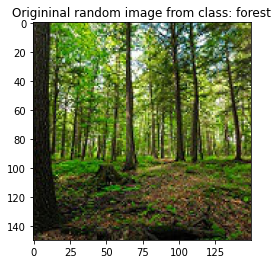

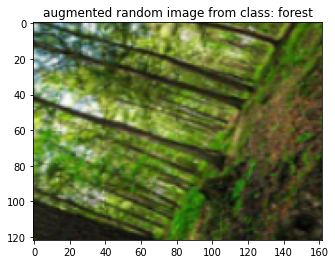

In [61]:
# checking augmentation layer results on random image 
target_dir = train_path
target_class = random.choice(class_names)
target_dir = f"{target_dir}/{target_class}"
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

print(random_image_path)
# Read in the random image
img = mpimg.imread(random_image_path)

plt.title(f"Origininal random image from class: {target_class}")
# plt.axis(False)
plt.imshow(img);

# Now lets plot our augmented random image
augmented_image = augmentation_layer(img, training=True)
plt.figure()
plt.title(f"augmented random image from class: {target_class}")
plt.imshow(augmented_image)

**Creating base model using ResNet50V2**

In this code snippet, a ResNet50V2 model is being instantiated as a base model with the include_top argument set to False. The include_top argument controls whether or not to include the fully-connected layer at the top of the network. Setting it to False means that the fully-connected layer will not be included in the model.

The base_model.trainable attribute is then set to False, which means that the model's weights will not be updated during training. This can be useful if you want to use the model as a fixed feature extractor, where you only want to train the layers above the base model.


*   The input_layer is being passed through augmented layer first in the model.
*   The GlobalAveragePooling2D layer is a layer that takes the output of the base model and applies global average pooling, which reduces the spatial dimensions of the data by taking the average of all the values in each channel.
*   The output_layer is a Dense layer with len(class_names) units and a softmax activation function.

In [62]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# set seed
tf.random.set_seed(RANDOM_SEED)

base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Creating input layer
input_layer = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,), name="input_layer")
x = augmentation_layer(input_layer)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2d_layer")(x)
output_layer = Dense(len(class_names), activation=softmax, name="output_layer")(x)

model_1 = tf.keras.Model(input_layer, output_layer)

In [ ]:
# base_model.summary()

**Model summary discussion**

This output is a summary of a TensorFlow model. It displays the layers in the model, along with their types, output shapes, and number of parameters.

The model has five layers:


1.   input_layer: an Input layer with shape (None, 150, 150, 3) and 0 parameters. This layer expects image data with a height and width of 150 and 3 color channels (RGB).
2.   augmentation_layer: a Sequential layer with shape (None, None, 3) and 0 parameters. This layer applies data augmentation to the input data.
3.   resnet50v2: a Functional layer with shape (None, None, None, 2048) and 23,564,800 parameters. This is the ResNet50V2 model that was instantiated earlier with the include_top argument set to False. It is being used as a fixed feature extractor and the weights of the model are not being updated during training.
4.   global_average_pooling_2d_layer: a GlobalAveragePooling2D layer with shape (None, 2048) and 0 parameters. This layer reduces the spatial dimensions of the data by taking the average of all the values in each channel.
5.  output_layer: a Dense layer with shape (None, 6) and 12,294 parameters. This layer has len(class_names) units and a softmax activation function, and is used to make predictions.

The model has a total of 23,577,094 parameters, of which 12,294 are trainable and 23,564,800 are non-trainable. The trainable parameters are the weights of the output_layer, which are being updated during training. The non-trainable parameters are the weights of the base model (resnet50v2), which are not being updated during training.

In [63]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, None, 3)          0         
 ial)                                                            
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling_2d_l  (None, 2048)             0         
 ayer (GlobalAveragePooling2                                     
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 6)                 12294     
                                                           

**Tensorflow Callbacks**



1.   Early stopping: In this code snippet, the EarlyStopping callback is being instantiated with the monitor argument set to "val_loss" and the patience argument set to 3 which means that training will be stopped if the validation loss has not improved for 3 epochs. (It can be useful for avoiding overfitting and for conserving computational resources)
2.   Reduce laerning rate: In this code snippet, the ReduceLROnPlateau callback is being instantiated with the monitor argument set to "val_loss", the factor argument set to 0.2, the patience argument set to 2, the verbose argument set to 1, and the min_lr argument set to 1e-7. Here, 

*   The monitor argument specifies which metric to use for reducing the learning rate.
*   The factor argument specifies the factor by which the learning rate will be reduced when the callback is triggered
*   The patience argument specifies the number of epochs to wait before reducing the learning rate when the metric has not improved.
*   The verbose argument controls the amount of output that the callback generates.
*   The min_lr argument specifies the minimum learning rate that the callback will allow. 

  (The ReduceLROnPlateau callback can be useful for avoiding getting stuck in a local minimum and for speeding up training. By setting the monitor, factor, patience, verbose, and min_lr arguments, you can control how the callback behaves and decide when to reduce the learning rate based on the performance of the model.)


3.   Checkpoint: It is a snapshot of the weights of a model at a particular point in training. It can be used to save the state of the model during training, so that you can resume training from the same point later on. This can be useful if you want to train a model for a long time and don't want to lose progress due to an interruption or if you want to try out different training configurations and compare their results.
2.   List item











In [64]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

# set checkpoint path
checkpoint_path = "checkpoint_weights/checkpoint.cpk"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    save_freq="epoch", #save every epoch
    verbose=1
)

**Compile the model**

Compiling a model in TensorFlow involves specifying the loss function, optimizer, and metrics that the model will use during training.


*   The loss function is a measure of how well the model is doing on the task it was designed for i.e. the loss function is the categorical cross-entropy loss for this model
*   The optimizer is an algorithm that is used to adjust the model's weights in order to minimize the loss i.e. the optimizer is the Adam optimizer
*   The metrics are used to evaluate the model's performance during training and testing.i.e., the metric is "accuracy" in this case.

In [65]:
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

**Fit the model**

In [66]:
history_1 = model_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        early_stopping_callback,
        reduce_lr_callback,
        checkpoint_callback
    ]
)

Epoch 1/5
439/439 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.7907
Epoch 1: val_loss improved from inf to 0.25196, saving model to checkpoint_weights/checkpoint.cpk
439/439 [==============================] - 994s 2s/step - loss: 0.5686 - accuracy: 0.7907 - val_loss: 0.2520 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 2/5
439/439 [==============================] - ETA: 0s - loss: 0.4253 - accuracy: 0.8472
Epoch 2: val_loss did not improve from 0.25196
439/439 [==============================] - 977s 2s/step - loss: 0.4253 - accuracy: 0.8472 - val_loss: 0.3296 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 3/5
439/439 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8528
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 3: val_loss did not improve from 0.25196
439/439 [==============================] - 1065s 2s/step - loss: 0.4027 - accuracy: 0.8528 - val_loss: 0.2574 - val_accuracy: 0.9085 - lr: 0.0010
Epoch 4/5

**Saving the trained model in drive**

In this code snippet, the model_1 is being saved using the save() method. This method allows you to save the weights, architecture, and optimizer state of a model in a single file.

The save() method takes a file path as an argument and saves the model to that file path in the HDF5 format, which is a widely supported format for storing large amounts of data. 

In [67]:
model_1.save('/content/drive/My Drive/ML_models/model_1.h5')

In [68]:
# Loading the model if required
# from tensorflow.keras.models import load_model
# model_1 = load_model('/content/drive/My Drive/ML_models/model_1.h5')

In [57]:
# load in saved model wights and evaluate model
model_1.load_weights(checkpoint_path)

**Evaluataing the trained model over test data**

In [69]:
model_1.evaluate(test_data)

94/94 [==============================] - 204s 2s/step - loss: 0.3099 - accuracy: 0.8903


[0.3098866045475006, 0.890333354473114]

**Ploting Loss and Accuracy**

In [70]:
import matplotlib.pyplot as plt
def plot_loss_curve(history):
    loss = history_1.history['loss']
    val_loss = history_1.history['val_loss']

    accuracy = history_1.history["accuracy"]
    val_accuracy = history_1.history["val_accuracy"]

    epochs = range(len(history_1.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training Loss', 'Validation Loss'])

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])

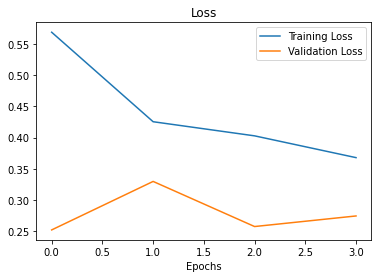

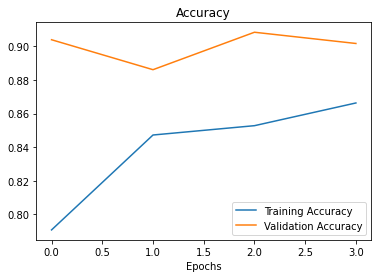

In [71]:
plot_loss_curve(history_1)

**Improving the model**

In this code snippet, the trainable attribute of the base_model is being set to True, and then the trainable attribute of the layers in the base_model is being set to False for all layers except the last 20 layers.

By setting the trainable attribute of the base_model to True, you are allowing the weights of all the layers in the base_model to be updated during training. However, by setting the trainable attribute of the first few layers to False, you are preventing the weights of those layers from being updated. This means that the last 20 layers of the base_model will be updated during training, while the first few layers will remain fixed.

(This can be useful because we want to use the base_model as a fixed feature extractor and only train the last few layers for image classification. Also,by freezing the weights of the earlier layers, we can avoid changing the features that the base_model has learned and focus on fine-tuning the last few layers for the task at hand.)

In [73]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# set seed
tf.random.set_seed(RANDOM_SEED)


base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

In [74]:
model_1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

**Checking the results of tune/ updated model**

In [78]:
# fine tune for another 2 epochs

fine_tune_epochs = EPOCHS + 2

# Refit the model (same as model_2 except with more trainable layers)
history_2 = model_1.fit(
    train_data,
    epochs=fine_tune_epochs,
    validation_data=test_data,
    steps_per_epoch=len(train_data),
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_1.epoch[-1],
    callbacks=[
        early_stopping_callback,
        reduce_lr_callback,
        checkpoint_callback
    ]
)

Epoch 4/7
439/439 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8702
Epoch 4: val_loss improved from 0.25196 to 0.12638, saving model to checkpoint_weights/checkpoint.cpk
439/439 [==============================] - 1411s 3s/step - loss: 0.3504 - accuracy: 0.8702 - val_loss: 0.1264 - val_accuracy: 0.9509 - lr: 1.0000e-04
Epoch 5/7
439/439 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.8928
Epoch 5: val_loss did not improve from 0.12638
439/439 [==============================] - 1413s 3s/step - loss: 0.3022 - accuracy: 0.8928 - val_loss: 0.1604 - val_accuracy: 0.9353 - lr: 1.0000e-04
Epoch 6/7
439/439 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.9050
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 6: val_loss did not improve from 0.12638
439/439 [==============================] - 1402s 3s/step - loss: 0.2658 - accuracy: 0.9050 - val_loss: 0.3207 - val_accuracy: 0.8638 - lr: 1.

In [79]:
model_1.save('/content/drive/My Drive/ML_models/model_1_tuned.h5')

**Comparing the performance history of model1 and the tuned model**

In [80]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5, metric: str = "accuracy"):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history[metric]
  loss = original_history.history["loss"]

  val_acc = original_history.history[f"val_{metric}"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history[metric]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history[f"val_{metric}"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

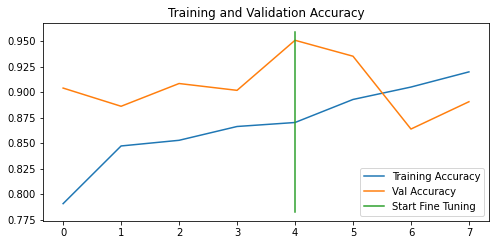

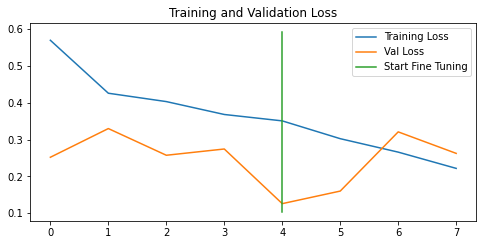

In [81]:
compare_historys(history_1, history_2)

In [82]:
# load in saved model weights and evaluate model
model_1.load_weights(checkpoint_path)

In [83]:
model_1.evaluate(test_data)

94/94 [==============================] - 198s 2s/step - loss: 0.2861 - accuracy: 0.8997


[0.2860569953918457, 0.8996666669845581]

**Making predictions**

In [84]:
# Make predictions with model
preds_probs = model_1.predict(test_data)
preds_probs[:10]

94/94 [==============================] - 196s 2s/step


array([[9.9997491e-01, 9.5188302e-09, 5.1544121e-06, 3.7686948e-07,
        1.1146251e-06, 1.8502191e-05],
       [9.9862999e-01, 9.1308010e-07, 2.9640123e-05, 1.7237564e-05,
        2.9296816e-05, 1.2928674e-03],
       [9.9974954e-01, 4.6783029e-08, 3.9154243e-06, 1.2493776e-05,
        8.2561055e-05, 1.5141905e-04],
       [9.9814880e-01, 6.3859488e-08, 1.8434195e-05, 1.0041714e-04,
        1.5162848e-03, 2.1599051e-04],
       [9.7985554e-01, 2.4451316e-05, 4.7422363e-03, 7.8780130e-03,
        6.4486228e-03, 1.0509894e-03],
       [8.5936296e-01, 3.6038629e-05, 1.0296695e-03, 5.2285199e-03,
        1.0703347e-01, 2.7309390e-02],
       [9.9667132e-01, 1.2763061e-05, 9.6200686e-04, 2.1683810e-04,
        4.6063331e-04, 1.6764142e-03],
       [5.0628740e-01, 5.7505498e-05, 7.4381783e-04, 4.7470801e-04,
        4.1236918e-04, 4.9202421e-01],
       [9.8466015e-01, 5.0153740e-06, 1.4165779e-04, 2.1858506e-05,
        1.7743051e-03, 1.3396920e-02],
       [9.9957794e-01, 1.8253156e-07,

In [85]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [86]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**Reports**

In [87]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.8996666666666666

**Make_confusion_matrix function explanation:**
Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.

    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:

    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:

    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)


In [88]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  # Makes a labelled confusion matrix comparing predictions and ground truth labels.
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

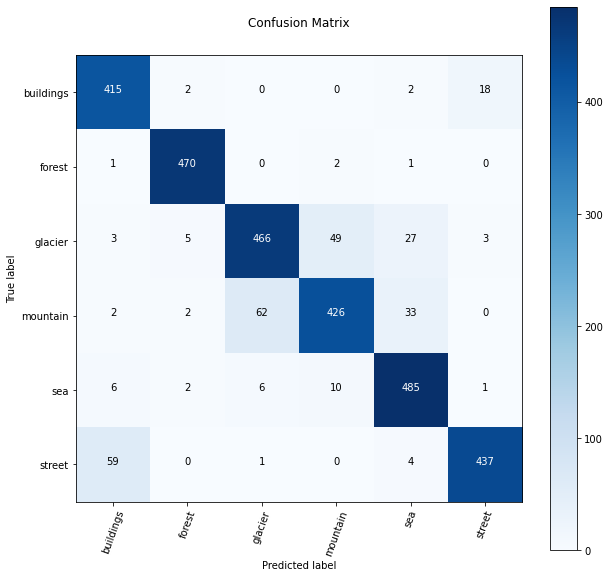

In [91]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=10)

In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       437
           1       0.98      0.99      0.98       474
           2       0.87      0.84      0.86       553
           3       0.87      0.81      0.84       525
           4       0.88      0.95      0.91       510
           5       0.95      0.87      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



In [93]:
from sklearn.metrics import classification_report
import pandas as pd

def get_f1_score_on_every_class_name(y_labels, y_true, class_names):
    """Return f1 score on every class name as a dataframe

    Args:
        y_labels (_type_): y_true of test_
        y_pred (_type_): predictions list

    Returns:
        pd.DataFrame: f1-scores dataframe on every class name
    """
    classification_report_dict = classification_report(y_labels, y_true, output_dict=True)
    # Create empty dictionary
    class_f1_scores = {}
    # Loop through classification report dictionary items
    for k, v in classification_report_dict.items():
        if k == "accuracy": # stop once we get to accuracy key
            break
        else:
            # Add class names and f1-scores to new dictionary
            class_f1_scores[class_names[int(k)]] = v["f1-score"]
    class_f1_scores

    # Trun f1-scores into dataframe for visualization
    f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                            "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
    return f1_scores

f1_scores = get_f1_score_on_every_class_name(y_labels=y_labels, y_true=pred_classes, class_names=class_names)
f1_scores

,class_names,f1-score
1,forest,0.984293
4,sea,0.913371
5,street,0.910417
0,buildings,0.899242
2,glacier,0.856618
3,mountain,0.841897


In [94]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_f1_scores_on_every_class_name(f1_scores, figsize = (10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
    ax.bar_label(scores, label_type='center', c="white")
    ax.set_yticks(range(len(f1_scores)))
    ax.set_yticklabels(f1_scores["class_names"])
    ax.set_xlabel("F1-score")
    ax.set_title("F1-scores for 101 Different Food Classes")
    ax.invert_yaxis(); # reverse the order of our plot

**Checking model on random data in validation set**

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_f1_scores_on_every_class_name(f1_scores, figsize = (10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
    ax.bar_label(scores, label_type='center', c="white")
    ax.set_yticks(range(len(f1_scores)))
    ax.set_yticklabels(f1_scores["class_names"])
    ax.set_xlabel("F1-score")
    ax.set_title("F1-scores for 101 Different Food Classes")
    ax.invert_yaxis(); # reverse the order of our plot

In [97]:
# # Make preds on a series of random images
# import os
# import random

# PRED_DIR: str ="/content/seg_pred/seg_pred"
# plt.figure(figsize=(17, 10))
# for i in range(3):
#   # Choose random image(s) from random class(es)
#   filename = random.choice(os.listdir(PRED_DIR))
#   filepath = PRED_DIR + "/" + filename
#   print(filepath)
#   # Load the image and make predictions
#   img = load_and_prep_image(filepath, scale=False)
#   img_expanded = tf.expand_dims(img, axis=0)
#   pred_prob = model_1.predict(img_expanded)
#   pred_class = class_names[pred_prob.argmax()]

#   plt.subplot(1, 3, i+1)
#   plt.imshow(img/225.)
#   plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
#   plt.axis(False);